In [1]:
#import processing
from PIL import Image
import os
import pandas as pd
import numpy as np
import skgstat as skg
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import itertools
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
'''
TODO:
1. Standardize file formats?

'''

'\nTODO:\n1. Standardize file formats?\n\n'

In [3]:
sgsdir = "SGS_training_sample/parquet"
dcgandir = "256_dcgan_cp_150/256_dcgan_cp_150"
diffusiondir = "256_sim_cp_10_100_sample.csv"


coord = pd.read_csv("coords_256.csv").values

In [4]:
#SGS - 50 realizations
sgs = np.empty((len(os.listdir(sgsdir)), 256, 256))

for i, name in enumerate(os.listdir(sgsdir)):
    sgs[i] = pd.read_parquet(sgsdir+"/"+name).values.reshape(300,300)[:256, :256]

In [5]:
sgs = (sgs + 1)/2

In [6]:
coord.shape, sgs.shape

((65536, 2), (87, 256, 256))

In [7]:
x_uniq = np.unique(coord[:, 0])
y_uniq = np.unique(coord[:, 1])

xx, yy = np.meshgrid(x_uniq, y_uniq)

xx.shape, yy.shape

((256, 256), (256, 256))

## DCGAN

In [8]:
# DCGAN - 100 samples
dcgan = np.empty((len(os.listdir(dcgandir)), 256, 256))

for i, name in enumerate(os.listdir(dcgandir)):
        path = os.path.join(dcgandir, name)
        image = Image.open(path).convert('L')
        image_normalized = np.array(image, dtype=np.float32) / 255.0
        
        
        dcgan[i] = image_normalized

dcgan.shape

(100, 256, 256)

## Diffusion

In [9]:
# Diffusion - 50 samples (randomly sampled from 100 original -- too big to push to repo!)

diffusion = pd.read_csv(diffusiondir, header = None).iloc[:,1:]
diffusion = diffusion.to_numpy().reshape((diffusion.shape[0], 256, 256))
diffusion.shape

(50, 256, 256)

In [10]:
plots = [
    np.mean(sgs, axis=0),
    np.mean(dcgan, axis=0),
    np.mean(diffusion, axis=0),
    np.var(sgs, axis=0),
    np.var(dcgan, axis=0),
    np.var(diffusion, axis=0)
]

titles = [
    'SGS mean',
    'DCGAN mean',
    'Diffusion mean',
    'SGS var',
    'DCGAN var',
    'Diffusion var'
]

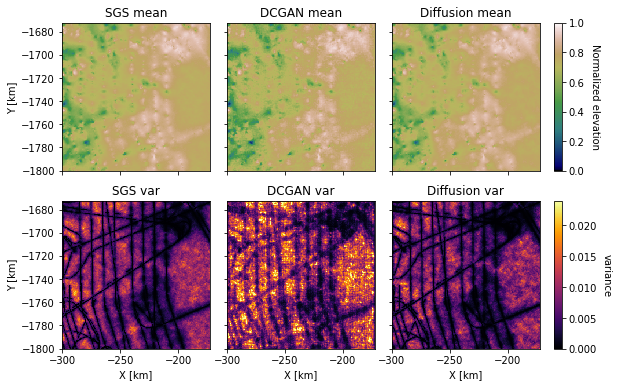

In [11]:
var_vmax = np.max(np.var(sgs, axis=0))

fig = plt.figure(figsize=(9,6))
spec = GridSpec(ncols=4, nrows=2, figure=fig, width_ratios=[1, 1, 1, 0.05], hspace=0.2, wspace=0.1)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[0, 2])
ax4 = fig.add_subplot(spec[1, 0])
ax5 = fig.add_subplot(spec[1, 1])
ax6 = fig.add_subplot(spec[1, 2])
axs = [ax1, ax2, ax3, ax4, ax5, ax6]

for i, (ax, plot, title) in enumerate(zip(axs, plots, titles)):
    if i < 3:
        im1 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=0, vmax=1, cmap='gist_earth')
    else:
        im2 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=0, vmax=var_vmax, cmap='inferno')
        ax.set_xlabel('X [km]')
    ax.set_title(title)
    ax.axis('scaled')

ax1.set_ylabel('Y [km]')
ax4.set_ylabel('Y [km]')

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels([])
for ax in [ax2, ax3, ax5, ax6]:
    ax.set_yticklabels([])

cax = fig.add_subplot(spec[0, 3])
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label('Normalized elevation', rotation=270, labelpad=15)

cax = fig.add_subplot(spec[1, 3])
cbar = plt.colorbar(im2, cax=cax)
cbar.set_label('variance', rotation=270, labelpad=15)

plt.savefig('Plots/mean_var_grid.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Sampling 5 realizations from each model for variogram calculation

random.seed(0)
sgs_sample_index = random.sample(range(sgs.shape[0]), 5)
dcgan_sample_index = random.sample(range(dcgan.shape[0]), 5)
diffusion_sample_index = random.sample(range(diffusion.shape[0]), 5)

In [13]:
# Plotting and variogram params

maxlag = 50000
n_lags = 30
downsample = 0.1

from itertools import cycle
cycol = cycle('bgrcm')

In [14]:
# SGS variograms

sgs_sample = []

for i in sgs_sample_index:
    vario = skg.Variogram(coord, sgs[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = False, samples = downsample)
    sgs_sample.append(vario)

In [15]:
#DCGAN variograms

dcgan_sample = []

for i in dcgan_sample_index:
    vario = skg.Variogram(coord, dcgan[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = False, samples = downsample)
    dcgan_sample.append(vario)

In [16]:
# Diffusion Variograms

diffusion_sample = []

for i in diffusion_sample_index:
    vario = skg.Variogram(coord, diffusion[i].reshape(256**2), bin_func = 'even', n_lags = n_lags, maxlag = maxlag, normalize = False, samples = downsample)
    diffusion_sample.append(vario)

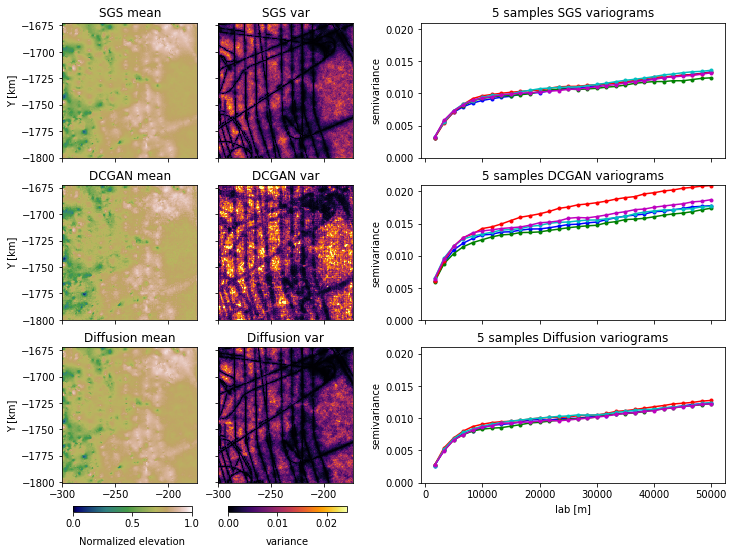

In [17]:
fig = plt.figure(figsize=(12,9))
gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 0.013], hspace=0.1, wspace=0.2)
gs1 = GridSpecFromSubplotSpec(3, 2, subplot_spec=gs[0,0], wspace=0.05)
gs2 = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0,1])
#spec = gridspec.GridSpec(ncols=3, nrows=4, figure=fig, width_ratios=[1, 1, 1.5], height_ratios=[1, 1, 1, 0.05], hspace=0.2, wspace=0.1)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs2[0])
ax4 = fig.add_subplot(gs1[1, 0])
ax5 = fig.add_subplot(gs1[1, 1])
ax6 = fig.add_subplot(gs2[1])
ax7 = fig.add_subplot(gs1[2, 0])
ax8 = fig.add_subplot(gs1[2, 1])
ax9 = fig.add_subplot(gs2[2])

axs = [ax1, ax2, ax4, ax5, ax7, ax8]

plots = [
    np.mean(sgs, axis=0),
    np.var(sgs, axis=0),
    np.mean(dcgan, axis=0),
    np.var(dcgan, axis=0),
    np.mean(diffusion, axis=0),
    np.var(diffusion, axis=0)
]

titles = [
    'SGS mean',
    'SGS var',
    'DCGAN mean',
    'DCGAN var',
    'Diffusion mean',
    'Diffusion var'
]

for i, (ax, plot, title) in enumerate(zip(axs, plots, titles)):
    if i%2==0:
        im1 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=0, vmax=1, cmap='gist_earth')
    else:
        im2 = ax.pcolormesh(xx/1000, yy/1000, plot, vmin=0, vmax=var_vmax, cmap='inferno')
    ax.set_title(title)
    ax.axis('scaled')

for data in sgs_sample:
        ax3.plot(data.bins, data.experimental, '.-', c= next(cycol))
        ax3.set_title('5 samples SGS variograms')
for data in dcgan_sample:
        ax6.plot(data.bins, data.experimental, '.-', c= next(cycol))
        ax6.set_title('5 samples DCGAN variograms')
for data in diffusion_sample:
        ax9.plot(data.bins, data.experimental, '.-', c= next(cycol))
        ax9.set_title('5 samples Diffusion variograms')

ax1.set_ylabel('Y [km]')
ax4.set_ylabel('Y [km]')
ax7.set_ylabel('Y [km]')

for ax in [ax3, ax6, ax9]:
    ax.set_ylabel('semivariance')

ax9.set_xlabel('lab [m]')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xticklabels([])
for ax in [ax2, ax5, ax8]:
    ax.set_yticklabels([])

for ax in [ax3, ax6, ax9]:
    ax.set_ylim([0,0.021])

gs3 = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[1, 0])
gs4 = GridSpecFromSubplotSpec(1, 64, subplot_spec=gs3[0])
cax = fig.add_subplot(gs4[8:63])
cbar = plt.colorbar(im1, cax=cax, use_gridspec=True, location='bottom')
cbar.set_label('Normalized elevation', labelpad=8)

gs6 = GridSpecFromSubplotSpec(1, 64, subplot_spec=gs3[1])
cax = fig.add_subplot(gs6[3:58])
cbar = plt.colorbar(im2, cax=cax, location ='bottom')
cbar.set_label('variance', labelpad=8)

plt.savefig('Plots/mean_var_vario_grid.png', dpi=300, bbox_inches='tight')
plt.show()